In [90]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#import json
from google.cloud import bigquery
from datetime import datetime,timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_validate

from sklearn.metrics import classification_report


In [2]:
#Localisation du projet name et table_id sur gcp
project="marbotic"

In [3]:
#intégration des credentials 
from google.oauth2 import service_account

key_path = "/Users/antonin/code/AntoninAnq/gcp/marbotic-7d02fac30bd8.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

In [4]:
def extract(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT
    COUNT(DISTINCT ep.Activity_Name) as unique_activity, 
    sm.session_id,sum(Time_Spent) as Time_Spent,
    any_value(Action_Element_Name) as Action_Element_Name,
    any_value(Profile_Age_days) as Profile_Age_days,
    (SAFE_DIVIDE(SUM(event_type_Activity_Good_Answer) , (SUM(event_type_Activity_Good_Answer)
    + SUM(event_type_Activity_Wrong_Answer))))*100 as good_answer_ratio
    FROM `marbotic.marbotic_dataset.event_properties` as ep
    JOIN `marbotic.marbotic_dataset.sessions_metrics` as sm on ep.session_id = sm.session_id
    GROUP BY sm.session_id
    ORDER BY unique_activity DESC
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [5]:
#On récupère d'event le nombre d'activity unique par session, le ratio de bonne réponse par sessions et le time spent par sessions
first_data = extract(project,credentials)
first_data

,unique_activity,session_id,Time_Spent,Action_Element_Name,Profile_Age_days,good_answer_ratio
0,42,1.648054e+12,19329.0,Back,1899.0,100.0
1,41,1.646647e+12,21882.0,Back,8434.0,NaN
2,40,1.646297e+12,54083.0,Back,1968.0,100.0
3,39,1.647908e+12,9693.0,Back,2376.0,100.0
4,38,1.646244e+12,16048.0,Back,2227.0,100.0
...,...,...,...,...,...,...
18811,0,1.652122e+12,1716.0,None,NaN,NaN
18812,0,1.652125e+12,546.0,None,NaN,NaN
18813,0,1.652152e+12,873.0,None,NaN,NaN
18814,0,1.652294e+12,985.0,None,NaN,NaN


In [6]:
def extract_session_metrics(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT *
    FROM `marbotic.marbotic_dataset.sessions_metrics`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [7]:
session_metrics_df = extract_session_metrics(project,credentials)
session_metrics_df

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear,session_start,game_events,setup_events
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,0.0,0.0,0.0,5.0,1.0,0.0,0.0,2022-03-16 08:56:40.722000+00:00,6.0,0.0
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2022-03-16 08:58:28.269000+00:00,5.0,0.0
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2022-03-24 15:06:21.426000+00:00,5.0,0.0
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2022-03-16 08:57:48.381000+00:00,5.0,0.0
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2022-03-07 08:24:40.937000+00:00,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.646491e+12,Notting Hill Gate,English,15.1,Royal Kensington and Chelsea,United Kingdom,iPad 6,1.0.7,2022-03-05 14:40:14.517000+00:00,5,...,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2022-03-05 14:39:48.894000+00:00,5.0,0.0
18812,1.652027e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 16:39:55.181000+00:00,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-08 16:32:21.326000+00:00,0.0,0.0
18813,1.652029e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 17:01:24.501000+00:00,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-08 16:58:54.378000+00:00,0.0,0.0
18814,1.652377e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-12 18:05:34.559000+00:00,19,...,0.0,0.0,0.0,10.0,4.0,0.0,0.0,2022-05-12 17:38:47.898000+00:00,19.0,0.0


In [8]:
#on merge les première colonnes crées avec la table sessions metrics
sm_df = session_metrics_df.merge(first_data, on='session_id')

In [9]:
#Calcul du temps de chaque session
sm_df['duration_min'] = (sm_df['session_end']-sm_df['session_start']).apply(lambda x: x.total_seconds()/60)

In [10]:
sm_df

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,event_type_Toast_Disappear,session_start,game_events,setup_events,unique_activity,Time_Spent,Action_Element_Name,Profile_Age_days,good_answer_ratio,duration_min
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,0.0,2022-03-16 08:56:40.722000+00:00,6.0,0.0,0,37.0,None,-1.0,NaN,1.558200
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,0.0,2022-03-16 08:58:28.269000+00:00,5.0,0.0,0,25.0,None,-1.0,NaN,0.285183
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,0.0,2022-03-24 15:06:21.426000+00:00,5.0,0.0,0,28.0,None,-1.0,NaN,0.240200
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,0.0,2022-03-16 08:57:48.381000+00:00,5.0,0.0,0,20.0,None,-1.0,NaN,0.191067
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,0.0,2022-03-07 08:24:40.937000+00:00,6.0,0.0,0,858.0,Back,1891.0,NaN,0.980767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.646491e+12,Notting Hill Gate,English,15.1,Royal Kensington and Chelsea,United Kingdom,iPad 6,1.0.7,2022-03-05 14:40:14.517000+00:00,5,...,0.0,2022-03-05 14:39:48.894000+00:00,5.0,0.0,0,31.0,None,-1.0,NaN,0.427050
18812,1.652027e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 16:39:55.181000+00:00,17,...,0.0,2022-05-08 16:32:21.326000+00:00,0.0,0.0,0,2525.0,None,4930.0,NaN,7.564250
18813,1.652029e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 17:01:24.501000+00:00,20,...,0.0,2022-05-08 16:58:54.378000+00:00,0.0,0.0,1,834.0,None,4930.0,NaN,2.502050
18814,1.652377e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-12 18:05:34.559000+00:00,19,...,0.0,2022-05-12 17:38:47.898000+00:00,19.0,0.0,1,9393.0,Back,4934.0,100.0,26.777683


In [11]:
def extract_user_metrics(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT user_creation_time, user_id
    FROM `marbotic.marbotic_dataset.users_metrics`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [12]:
user_metrics_df = extract_user_metrics(project,credentials)

In [13]:
#on merge la date de création dans le cas ou on veut calculer la maturité du user au moment de la session. Non utilisé dans un premier temps
sm_df = sm_df.merge(user_metrics_df, on='user_id')

In [14]:
sm_df

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,session_start,game_events,setup_events,unique_activity,Time_Spent,Action_Element_Name,Profile_Age_days,good_answer_ratio,duration_min,user_creation_time
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,2022-03-16 08:56:40.722000+00:00,6.0,0.0,0,37.0,None,-1.0,NaN,1.558200,2021-11-20 15:17:18.537000+00:00
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,2022-03-16 08:58:28.269000+00:00,5.0,0.0,0,25.0,None,-1.0,NaN,0.285183,2021-11-20 15:17:18.537000+00:00
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,2022-03-24 15:06:21.426000+00:00,5.0,0.0,0,28.0,None,-1.0,NaN,0.240200,2021-11-20 15:17:18.537000+00:00
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,2022-03-16 08:57:48.381000+00:00,5.0,0.0,0,20.0,None,-1.0,NaN,0.191067,2021-11-20 15:17:18.537000+00:00
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,2022-03-07 08:24:40.937000+00:00,6.0,0.0,0,858.0,Back,1891.0,NaN,0.980767,2021-12-07 18:08:20.505000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.649501e+12,Kensington,English,15.1,Royal Kensington and Chelsea,United Kingdom,"iPad12,1",1.0.5,2022-04-09 10:45:26.022000+00:00,1,...,2022-04-09 10:45:26.022000+00:00,1.0,0.0,1,3573.0,None,NaN,NaN,0.000000,2021-12-19 14:16:39.549000+00:00
18812,1.652027e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 16:39:55.181000+00:00,17,...,2022-05-08 16:32:21.326000+00:00,0.0,0.0,0,2525.0,None,4930.0,NaN,7.564250,2022-05-08 16:29:14.356000+00:00
18813,1.652029e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-08 17:01:24.501000+00:00,20,...,2022-05-08 16:58:54.378000+00:00,0.0,0.0,1,834.0,None,4930.0,NaN,2.502050,2022-05-08 16:29:14.356000+00:00
18814,1.652377e+12,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,2022-05-12 18:05:34.559000+00:00,19,...,2022-05-12 17:38:47.898000+00:00,19.0,0.0,1,9393.0,Back,4934.0,100.0,26.777683,2022-05-08 16:29:14.356000+00:00


In [15]:
#On calcul le nombre de sessions avant celle en cours
def nb_session(user_id,session_start):
    return sm_df[(sm_df['user_id']==user_id) & (sm_df['session_start']<session_start)].shape[0]

In [16]:
sm_df['previous_session'] = sm_df.apply(lambda x:nb_session(x.user_id,x.session_start), axis=1)

In [17]:
#On calcul le temps depuis la dernière sessions
def last_session_time(user_id,session_start):
    last_session = sm_df[(sm_df['user_id']==user_id) & (sm_df['session_start']<session_start)]\
    .sort_values(by='session_start',ascending=True)\
    .groupby('user_id').last()['session_start']
    if len(last_session.values)==0:
        return timedelta(0)
    else:
        last_session = last_session.dt.to_pydatetime()[0].replace(tzinfo=None)
        return (session_start.to_pydatetime().replace(tzinfo=None) - last_session)

In [18]:
#(sm_df[(sm_df['user_id']==65616.0) & (sm_df['session_start']<'2022-03-16 08:58:28.269000+00:00')].sort_values(by='session_start',ascending=True).groupby('user_id').last()['session_start'].dt.to_pydatetime()[0].replace(tzinfo=None))

In [19]:
sm_df['time_since_last_session'] = sm_df.apply(lambda x:last_session_time(x.user_id,x.session_start), axis=1)

In [20]:
#Vérification pour un utilisateur donné, le début de toutes ses sessions ordonné et l'écart avec la dernière session
sm_df[sm_df['user_id']==66337.0].sort_values(by='session_start',ascending=True)[['session_start','time_since_last_session']]

,session_start,time_since_last_session
10,2022-01-12 15:34:18.911000+00:00,0 days 00:00:00
11,2022-03-05 16:00:00.822000+00:00,52 days 00:25:41.911000
9,2022-03-05 20:23:34.583000+00:00,0 days 04:23:33.761000
6,2022-03-07 07:15:12.051000+00:00,1 days 10:51:37.468000
7,2022-03-07 07:52:31.465000+00:00,0 days 00:37:19.414000
4,2022-03-07 08:24:40.937000+00:00,0 days 00:32:09.472000
5,2022-05-09 09:50:43.882000+00:00,63 days 01:26:02.945000
8,2022-05-10 06:57:04.671000+00:00,0 days 21:06:20.789000
12,2022-05-10 14:45:39.525000+00:00,0 days 07:48:34.854000
16,2022-05-11 06:42:18.649000+00:00,0 days 15:56:39.124000


In [21]:
#sm_df.groupby('user_id').agg({'time_since_last_session':'mean','setup_events':sum,'game_events':sum,'id':'count'})['id'].value_counts()

In [24]:
#Durée moyenne entre deux sessions
sm_df[sm_df['time_since_last_session']!=timedelta(0)]['time_since_last_session'].mean()

Timedelta('3 days 04:41:50.486608937')

In [27]:
#Conversion de la colonne time_since_last_session timedelta en timestampe[min]
sm_df['time_since_last_session_min']=sm_df['time_since_last_session'].map(lambda x : x.total_seconds()/60)

**Ajout de la maturité au moment du début de la sessions**

In [28]:
sm_df["week_maturity"] =(sm_df["session_start"]-sm_df["user_creation_time"]).map(lambda x: int(np.ceil(x.days/7))+1)

**Ajout du type d'utilisateur depuis la table user_augmented**

In [29]:
def extract_user_type(project,credentials):
    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, credentials=credentials)

    query = """
    SELECT Type, user_id
    FROM `marbotic.marbotic_dataset.user_augmented`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [30]:
user_type_df = extract_user_type(project,credentials)
user_type_df

,Type,user_id
0,None,0
1,Parent,1220
2,Parent,1405
3,Parent,1957
4,Parent,2560
...,...,...
2622,Parent,73098
2623,Teacher,73127
2624,Teacher,73128
2625,Parent,73132


In [31]:
sm_df = sm_df.merge(user_type_df, on='user_id')

In [69]:
#Durée moyenne entre deux sessions pour les parents
sm_df[sm_df['Type']=='Parent'][sm_df['time_since_last_session']!=timedelta(0)]['time_since_last_session'].mean()

/var/folders/c7/kdqvz76x679f28lhd235r_v40000gn/T/ipykernel_65009/258057669.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sm_df[sm_df['Type']=='Parent'][sm_df['time_since_last_session']!=timedelta(0)]['time_since_last_session'].mean()


Timedelta('3 days 10:11:01.818812509')

In [73]:
week_maturity = sm_df['week_maturity']
min_last_session = sm_df['time_since_last_session_min']

In [78]:
sm_df.head()

,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,Action_Element_Name,Profile_Age_days,good_answer_ratio,duration_min,user_creation_time,previous_session,time_since_last_session,time_since_last_session_min,week_maturity,Type
0,1.647421e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:14.214000+00:00,6,...,None,-1.0,NaN,1.558200,2021-11-20 15:17:18.537000+00:00,0,0 days 00:00:00,0.000000,18,Teacher
1,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:58:45.380000+00:00,5,...,None,-1.0,NaN,0.285183,2021-11-20 15:17:18.537000+00:00,2,0 days 00:00:39.888000,0.664800,18,Teacher
2,1.648134e+12,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,2022-03-24 15:06:35.838000+00:00,5,...,None,-1.0,NaN,0.240200,2021-11-20 15:17:18.537000+00:00,3,8 days 06:07:53.157000,11887.885950,19,Teacher
3,1.647421e+12,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,2022-03-16 08:57:59.845000+00:00,5,...,None,-1.0,NaN,0.191067,2021-11-20 15:17:18.537000+00:00,1,0 days 00:01:07.659000,1.127650,18,Teacher
4,1.646641e+12,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,2022-03-07 08:25:39.783000+00:00,6,...,Back,1891.0,NaN,0.980767,2021-12-07 18:08:20.505000+00:00,5,0 days 00:32:09.472000,32.157867,14,Teacher


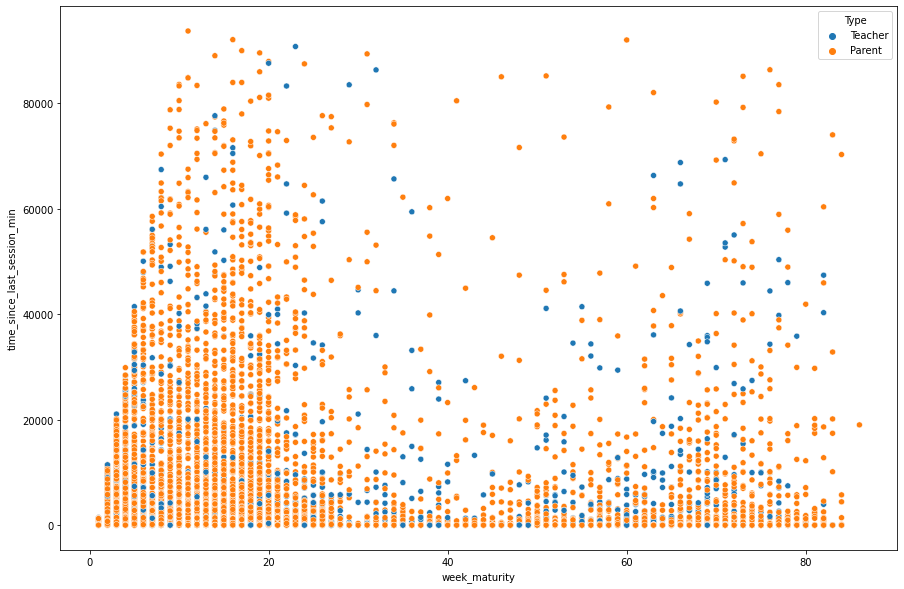

In [89]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=week_maturity,y=min_last_session,hue=sm_df['Type']);

In [95]:
#On drope la colone time_since_last_session en timedelta car incompatbile BQ
sm_df.drop('time_since_last_session',axis=1,inplace=True)

## Correlation

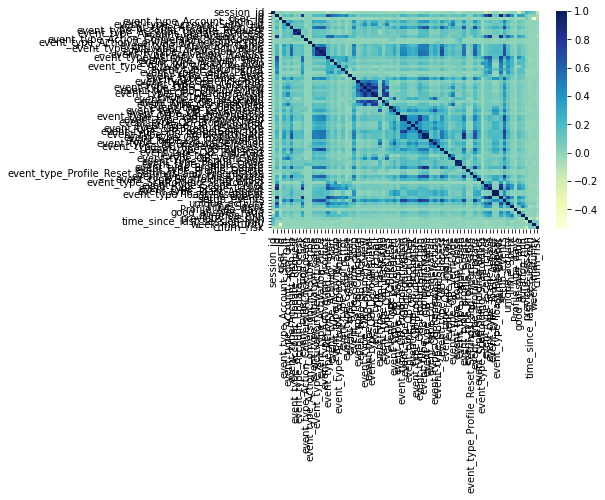

In [148]:
# Heatmap
corr = sm_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu");

In [149]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(20)

,feature_1,feature_2,correlation
4441,event_type_Toast_Appear,event_type_Toast_Disappear,0.990477
4513,event_type_Toast_Disappear,event_type_Toast_Appear,0.990477
2591,event_type_OB_ProductActivation,event_type_OB_ProductHelp,0.951336
2663,event_type_OB_ProductHelp,event_type_OB_ProductActivation,0.951336
135,id,game_events,0.940707
4527,game_events,id,0.940707
4369,event_type_Scene_Leave,game_events,0.937821
4585,game_events,event_type_Scene_Leave,0.937821
3107,event_type_OB_ProfileName,event_type_OB_ProfileBirthdate,0.921704
3035,event_type_OB_ProfileBirthdate,event_type_OB_ProfileName,0.921704


## Labelling

In [96]:
#On considère le seuil de churn à 3 semaine.
#On est en situation de churn si la session suivante arrive dans plus de 3 semaines.
CHURN_THRESHOLD = timedelta(days=21)

#On utilise une constante TODAY pour evaluer le risque de churn des dernières session.
#Dans notre cas TODAY est le max de session end. On considère que l'extract s'arrète au moment de la dernière session de jeu dont on dispose
TODAY = datetime(2022, 5, 13, 0, 0)

In [97]:
#sm_df[(sm_df['user_id']==65616.0)& ('2022-03-16 08:58:14.214000+00:00'<sm_df['session_end'])].sort_values(by='session_end',ascending=True).groupby('user_id').first()['session_start']

In [98]:
#On calcul le temps jusqu'à la prochaine sessions si superieur au seuil de churn. Label_risque de churn = 1
def labelling_churn(user_id,session_end,session_start,CHURN_THRESHOLD,today):
    next_session = sm_df[(sm_df['user_id']==user_id) & (session_end<sm_df['session_end'])]\
    .sort_values(by='session_end',ascending=True)\
    .groupby('user_id').first()['session_start']
    if len(next_session.values) == 0:
        if today - session_start.to_pydatetime().replace(tzinfo=None)> CHURN_THRESHOLD :
            return 1
        else:
            return 0
    else:
        delta = (next_session - session_end)
        if delta.iloc[0] < CHURN_THRESHOLD:
            return 0
        else:
            return 1

In [99]:
sm_df['churn_risk'] = sm_df.apply(lambda x:labelling_churn(x.user_id,x.session_end,x.session_start,CHURN_THRESHOLD,TODAY), axis=1)

In [100]:
#Vérification du label de churn sur l'utilisateur déja vérifié plus haut.
sm_df[sm_df['user_id']==66337.0].sort_values(by='session_start',ascending=True)[['session_start','time_since_last_session_min','churn_risk']]

,session_start,time_since_last_session_min,churn_risk
10,2022-01-12 15:34:18.911000+00:00,0.000000,1
11,2022-03-05 16:00:00.822000+00:00,74905.698517,0
9,2022-03-05 20:23:34.583000+00:00,263.562683,0
6,2022-03-07 07:15:12.051000+00:00,2091.624467,0
7,2022-03-07 07:52:31.465000+00:00,37.323567,0
4,2022-03-07 08:24:40.937000+00:00,32.157867,1
5,2022-05-09 09:50:43.882000+00:00,90806.049083,0
8,2022-05-10 06:57:04.671000+00:00,1266.346483,0
12,2022-05-10 14:45:39.525000+00:00,468.580900,0
16,2022-05-11 06:42:18.649000+00:00,956.652067,0


In [101]:
sm_df[sm_df['Type']=='Parent']['churn_risk'].value_counts()

0    13090
1     1901
Name: churn_risk, dtype: int64

In [102]:
(1901/(13090+1901))*100

12.680941898472417

In [103]:
sm_df[sm_df['Type']=='Teacher']['churn_risk'].value_counts()

0    3495
1     329
Name: churn_risk, dtype: int64

In [104]:
(329/(329+3495))*100

8.603556485355648

## Cleaning

In [105]:
#No duplicates
sm_df.duplicated().sum()

0

In [106]:
((sm_df.isnull().sum().sort_values(ascending=False)/len(sm_df))*100).head(10)

good_answer_ratio                 52.651998
Action_Element_Name               34.390944
Profile_Age_days                  16.911139
Time_Spent                         0.031888
Type                               0.005315
event_type_OB_RenewalSelection     0.000000
event_type_Popup_Open              0.000000
event_type_Popup_Close             0.000000
event_type_OB_VerifCode            0.000000
event_type_OB_Type                 0.000000
dtype: float64

good_answer_ratio Nan correspond to session with no event type answer. On remplace les Nan par -1

In [107]:
answer_ratio_imputer = SimpleImputer(strategy='constant',fill_value=-1)
sm_df['good_answer_ratio'] = answer_ratio_imputer.fit_transform(sm_df[['good_answer_ratio']])

In [108]:
#34% de Nan, on drop cette colonne tant qu'on n'a pas d'information supplémentaire sur la signification des Nan
sm_df['Action_Element_Name'].value_counts()

Back                         9769
Home                          972
Play New Activity             751
Adults                        458
Replay Activity               179
Skip FTUE animation            52
Account Edit Informations      44
Action (Toast)                 39
Close (Toast)                  38
Let's Go                       35
Try Again (No Internet)         3
Validation                      2
Twitter                         1
Youtube                         1
Facebook                        1
Name: Action_Element_Name, dtype: int64

In [109]:
sm_df.drop('Action_Element_Name',axis=1,inplace=True)

In [110]:
#Pour Profile_Age_days(17%), Time_Spent(0.03) on remplace par la médiane car un énorme outlier(-2911184.0) et 3341 valeur = -1
med_imputer = SimpleImputer(strategy='median')
sm_df['Profile_Age_days'] = med_imputer.fit_transform(sm_df[['Profile_Age_days']])
sm_df['Time_Spent'] = med_imputer.fit_transform(sm_df[['Time_Spent']])

In [111]:
#Pour Type, il manque une valeur on remplace par most frequent
mmost_freq_imputer = SimpleImputer(missing_values=None,strategy='most_frequent')
sm_df['Type'] = mmost_freq_imputer.fit_transform(sm_df[['Type']])

In [112]:
((sm_df.isnull().sum().sort_values(ascending=False)/len(sm_df))*100).head(10)

session_id                      0.0
event_type_OB_RenewalSuccess    0.0
event_type_Profile_Delete       0.0
event_type_Profile_Create       0.0
event_type_Popup_Open           0.0
event_type_Popup_Close          0.0
event_type_OB_VerifCode         0.0
event_type_OB_Type              0.0
event_type_OB_TrialStart        0.0
event_type_OB_Success           0.0
dtype: float64

**Traitement des outliers extremes**

In [113]:
# A controle Time_spent max, Profile_Age_days min
#On supprime la session avec le time_spent = 17162486.0 de user_id = 23370.0 
#Il a 70 sessions avec une médiane de Time_spent 7571
sm_df[['Time_Spent']].max()

Time_Spent    17162486.0
dtype: float64

In [114]:
sm_df.shape

(18816, 84)

In [115]:
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==17162486.0].index,inplace=True)

In [116]:
#On supprime 2 autres lignes avec Time_Spent > 1 000 000 Cela concerne le même utilsateur qui a 20 sessions
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==2190329.0].index,inplace=True)
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==1093473.0].index,inplace=True)

In [117]:
# On supprime l'utilisateur avec un age énorme négatif. Session unique user_creation_time : 27-22-2021
sm_df.drop(axis=0,index=sm_df[sm_df['Profile_Age_days']==-2911184.0].index,inplace=True)

## processing des colonnes

In [118]:
sm_df.select_dtypes(include='object')

,city,language,os_version,region,country,device_model,start_version,Type
0,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,Teacher
1,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,Teacher
2,Certines,French,15.3.1,Ain,France,"iPad11,6",1.0.1,Teacher
3,Certines,French,15.1,Ain,France,"iPad11,6",1.0.1,Teacher
4,Izernore,French,15.2,Ain,France,iPad 6,1.0.3,Teacher
...,...,...,...,...,...,...,...,...
18811,Kensington,English,15.1,Royal Kensington and Chelsea,United Kingdom,"iPad12,1",1.0.5,Parent
18812,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,Parent
18813,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,Parent
18814,Hamburg,English,14.6,Free and Hanseatic City of Hamburg,Germany,iPad Pro,4.1.3,Parent


In [119]:
cat_transformer = OneHotEncoder(handle_unknown='ignore')
cat_selection = sm_df[['Type']].columns

In [194]:
#On retire des éléments très corrélés
num_transformer = MinMaxScaler()
num_selection = sm_df.select_dtypes(include=['float64','int64']).drop(['churn_risk','session_id','id','user_id','event_type_Toast_Disappear','event_type_OB_ProductHelp','event_type_OB_ProfileName'],axis=1).columns

In [201]:
preprocessor = make_column_transformer(
    (num_transformer,num_selection),
    (cat_transformer,cat_selection ),
    remainder = 'drop'
)

In [202]:
sm_df['churn_risk'].value_counts()[1]

2230

## Preparation du jeu de donnée

**On downsample les sessions sans churn risque pour en avoir autant que de churn risque**

In [203]:
sm_df_churn_risque = sm_df[sm_df['churn_risk']==1]

In [204]:
sm_df_no_churn_risque = sm_df[sm_df['churn_risk']==0]
sm_df_no_churn_risque = sm_df_no_churn_risque.loc[np.random.choice(sm_df_no_churn_risque.index,size = sm_df_churn_risque.shape[0])]

In [205]:
sm_df_balanced = pd.concat([sm_df_no_churn_risque,sm_df_churn_risque],axis=0)

In [206]:
X= sm_df_balanced.drop('churn_risk',axis=1).copy()
y = sm_df_balanced['churn_risk'].copy()

On sépare le jeu de donnée en train et test

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Feature selection

In [208]:
X_feature_sel = pd.DataFrame(preprocessor.fit_transform(X_train))

In [209]:
#Permet d'obtenir l'importance des features au regard des autres
#pour chaque modèle on l'entraine 10 fois en mélangeant les valeurs d'une colonne gardant toutes les autres identiques
 
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression().fit(X_feature_sel, y_train) # Fit model
# on peut mettre un keyworld arg max_iter=1000, par défaut le modèle a une limite (100, à vérifier)

permutation_score = permutation_importance(log_model, X_feature_sel, y_train, n_repeats=10) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X_feature_sel.columns,
                                        permutation_score.importances_mean)).T) # Unstack results
importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

,feature,score decrease
63,63.0,0.133600
65,65.0,0.006694
64,64.0,0.006438
17,17.0,0.004100
5,5.0,0.003459
...,...,...
11,11.0,-0.000673
10,10.0,-0.000769
36,36.0,-0.000801
66,66.0,-0.007367


**La méthode de feature permutation ne donne rien de pertinent**

## Model

In [210]:
pipe = make_pipeline(preprocessor, RandomForestClassifier())

In [211]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                    Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
          'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
          'event_type_Account_Update_Success', 'event_type_Action_Click',
          'event_type_Action_ConversionClickRedeem',
          'event_type_Action_ConversionClickSubscribe',
          'event_...
          'event_type_Scaffolding_Scaffolding', 'event_type_Scene_Enter',
          'event_type_Scene_Leave', 'event_type_Toast_Appear', 'game_events',
          'setup_events', 'unique_activity', 'Time_Spent', 'Profile_Age_days',
          'good_answer_ratio', 'duration_min', 'previous_session',
          'time_since_last_session_min', 'week_maturity'],
         dtype='object')),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unk

In [212]:
grid_search = GridSearchCV(
    pipe, 
    param_grid={
        'randomforestclassifier__max_depth': [30,35],
        'randomforestclassifier__min_samples_split': [25,30],
        'randomforestclassifier__n_estimators' : [300,400],
        'randomforestclassifier__max_samples' : [0.3]
    },
    cv=5,
    scoring="accuracy",
verbose=1)

In [213]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'randomforestclassifier__max_depth': 35,
 'randomforestclassifier__max_samples': 0.3,
 'randomforestclassifier__min_samples_split': 30,
 'randomforestclassifier__n_estimators': 300}

In [214]:
grid_search.best_score_

0.7203651282051282

In [215]:
best_search = grid_search.best_estimator_

In [216]:
y_pred = best_search.predict(X_test)

In [217]:
target_names = ['classe 0','Classe 1']
print(classification_report(y_test,y_pred,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.76      0.68      0.72       685
    Classe 1       0.70      0.78      0.73       653

    accuracy                           0.72      1338
   macro avg       0.73      0.73      0.72      1338
weighted avg       0.73      0.72      0.72      1338



## Upload dans BQ

**Upload de la table en cours dans BQ**

In [69]:
###Localisation du projet name et table_id sur gcp
#project="marbotic"
#table_id = "marbotic_dataset.session_augmented"
#client = bigquery.Client(project,credentials)
#
#job = client.load_table_from_dataframe(sm_df, table_id) 
#
#job.result()  # Wait for the job to complete.
#table = client.get_table(table_id)  # Make an API request.
#print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))

In [70]:
9000/(50)

180.0

In [72]:
180/2

90.0